In [1]:
import math
import os
import time

import imageio
import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import DEFunc, NeuralODE
from torchdyn.datasets import generate_moons
from torchdyn.nn import Augmenter

from torchcfm.conditional_flow_matching import ExactOptimalTransportConditionalFlowMatcher

In [2]:
def sample_moons(n):
    x0, _ = generate_moons(n, noise=0.2)
    return x0 * 3 - 1

def sample_normal(n):
    m = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2), torch.eye(2))
    return m.sample((n,))


def log_normal_density(x):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(x.shape[-1]), torch.eye(x.shape[-1])
    )
    return m.log_prob(x)

5000: loss 2.922 time 4.57


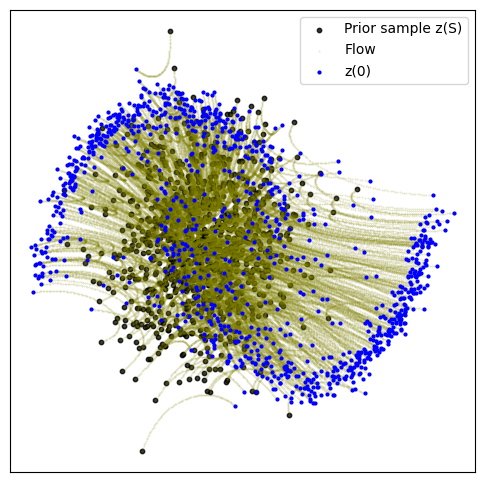

10000: loss 2.799 time 4.89


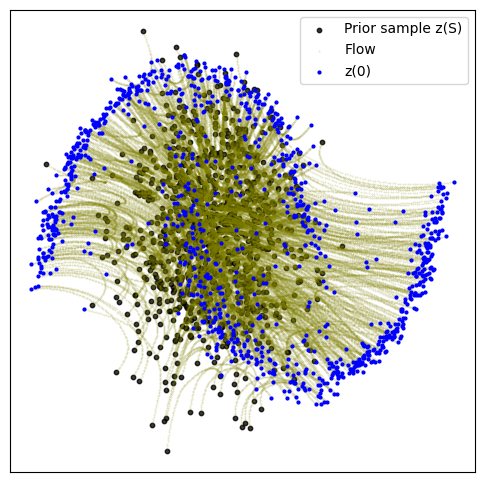

15000: loss 2.752 time 5.88


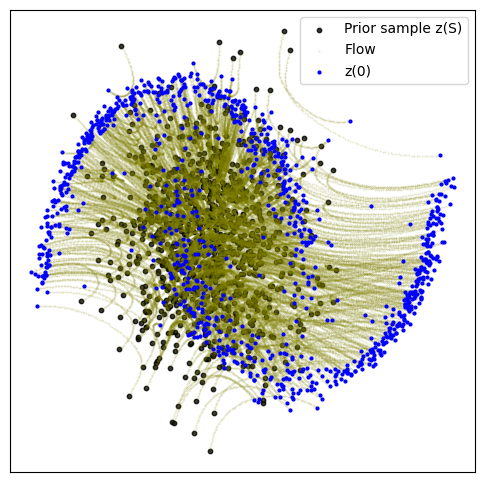

20000: loss 2.753 time 5.03


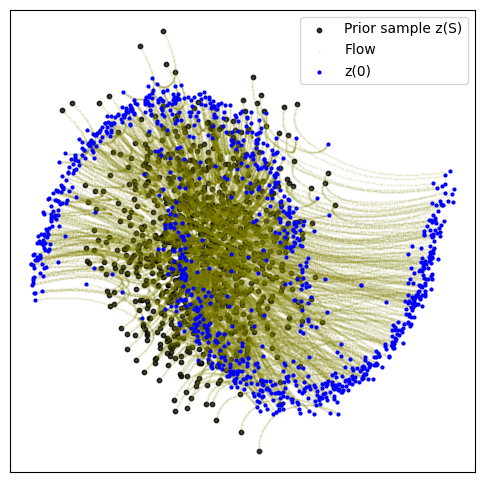

CPU times: user 22.7 s, sys: 1.42 s, total: 24.1 s
Wall time: 20.9 s


In [3]:
%%time

from torchcfm.models.models import MLP
from torchcfm.utils import torch_wrapper, plot_trajectories

sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
FM = ExactOptimalTransportConditionalFlowMatcher()
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
for k in range(20000):
    optimizer.zero_grad()

    x0 = sample_normal(batch_size)
    x1 = sample_moons(batch_size)

    t = torch.rand(x0.shape[0]).type_as(x0)
    xt = FM.sample_xt(x0, x1, t, epsilon=0.01)
    ut = FM.compute_conditional_flow(x0, x1, t, xt)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_normal(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())

In [4]:
def autograd_trace(x_out, x_in, **kwargs):
    """Standard brute-force means of obtaining trace of the Jacobian, O(d) calls to autograd"""
    trJ = 0.0
    for i in range(x_in.shape[1]):
        trJ += torch.autograd.grad(x_out[:, i].sum(), x_in, allow_unused=False, create_graph=True)[
            0
        ][:, i]
    return trJ

class CNF(torch.nn.Module):
    def __init__(self, net, trace_estimator=None, noise_dist=None):
        super().__init__()
        self.net = net
        self.trace_estimator = trace_estimator if trace_estimator is not None else autograd_trace
        self.noise_dist, self.noise = noise_dist, None

    def forward(self, t, x, *args, **kwargs):
        with torch.set_grad_enabled(True):
            x_in = x[:, 1:].requires_grad_(
                True
            )  # first dimension reserved to divergence propagation
            # the neural network will handle the data-dynamics here
            x_out = self.net(
                torch.cat([x_in, t * torch.ones(x.shape[0], 1).type_as(x_in)], dim=-1)
            )
            trJ = self.trace_estimator(x_out, x_in, noise=self.noise)
        return (
            torch.cat([-trJ[:, None], x_out], 1) + 0 * x
        )  # `+ 0*x` has the only purpose of connecting x[:, 0] to autograd graph

In [9]:
device = "cpu"

w = 7
points = 100j
device = "cpu"
Y, X = np.mgrid[-w:w:points, -w:w:points]
gridpoints = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1)).type(torch.float32)

points_small = 20j
points_real_small = 20
Y_small, X_small = np.mgrid[-w:w:points_small, -w:w:points_small]
gridpoints_small = torch.tensor(np.stack([X_small.flatten(), Y_small.flatten()], axis=1)).type(
    torch.float32
)

torch.manual_seed(42)
sample = sample_normal(1024)
ts = torch.linspace(0, 1, 101)
for i, t in enumerate(ts):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    cnf = DEFunc(CNF(model))
    nde = NeuralODE(cnf, solver="euler", sensitivity="adjoint")
    cnf_model = torch.nn.Sequential(Augmenter(augment_idx=1, augment_dims=1), nde)
    with torch.no_grad():
        if t > 0:
            aug_traj = (
                cnf_model[1]
                .to(device)
                .trajectory(
                    Augmenter(1, 1)(gridpoints).to(device),
                    t_span=torch.linspace(t, 0, 201).to(device),
                )
            )[-1].cpu()
            log_probs = log_normal_density(aug_traj[:, 1:]) - aug_traj[:, 0]
        else:
            log_probs = log_normal_density(gridpoints)
    # log_probs = log_probs.reshape(Y.shape)
    # ax.pcolormesh(X, Y, torch.exp(log_probs), vmax=0.18)
    # ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_xlim(-w, w)
    # ax.set_ylim(-w, w)
    # ax.set_title("OTCFM", fontsize=30)
    out = model(
        torch.cat(
            [gridpoints_small, torch.ones((gridpoints_small.shape[0], 1)) * t], dim=1
        ).to(device)
    )
    out = out.reshape([points_real_small, points_real_small, 2]).cpu().detach().numpy()
    ax.quiver(
        X_small,
        Y_small,
        out[:, :, 0],
        out[:, :, 1],
        np.sqrt(np.sum(out**2, axis=-1)),
        cmap="coolwarm",
        scale=100.0,
        width=0.010,
        pivot="mid",
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-w, w)

    # ax = axis[2]
    # sample_traj = traj = nde.trajectory(
    #             sample_normal(1024),
    #             t_span=torch.linspace(0, 1, 100),
    #         ).cpu().numpy()
    # ax.scatter(sample_traj[0, :, 0], sample_traj[0, :, 1], s=10, alpha=0.8, c="black")
    # ax.scatter(sample_traj[:i, :, 0], sample_traj[:i, :, 1], s=0.2, alpha=0.2, c="olive")
    # ax.scatter(sample_traj[i, :, 0], sample_traj[i, :, 1], s=4, alpha=1, c="blue")
    # ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_xlim(-w, w)
    # ax.set_ylim(-w, w)
    os.makedirs("figures/vector_field/", exist_ok=True)
    plt.savefig(f"figures/vector_field/{t:0.2f}.png", dpi=40)
    plt.close()

In [14]:
gif_name = "gaussians-to-moons"
with imageio.get_writer(f"{gif_name}.gif", mode="I") as writer:
    for filename in [f"figures/density/{t:0.2f}.png" for t in ts] + [
        f"figures/density/{ts[-1].item():0.2f}.png"
    ] * 10:
        image = imageio.imread(filename)
        writer.append_data(image)

/var/folders/0n/8hp9d_rj4_9d8vgrqztmqhf40000gn/T/ipykernel_23112/3576606257.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
